<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

In [ ]:
# instructor reccomends splicing
# visuals of token frequency
# clean data as much as possible
# lower case, no numeric
# follow rules of good tokens
# treat this as if you were working for one of these coffee shops (the practical application)

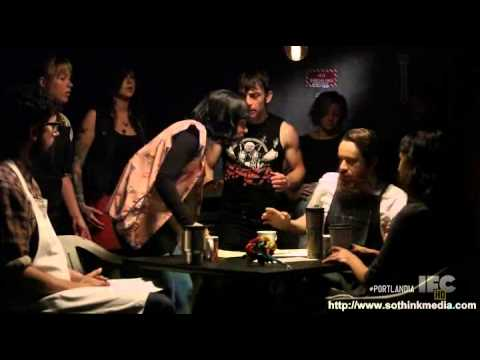

In [5]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/jonathansokoll/Documents/lambda/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [3]:
# Start here 
import re
import seaborn as sns

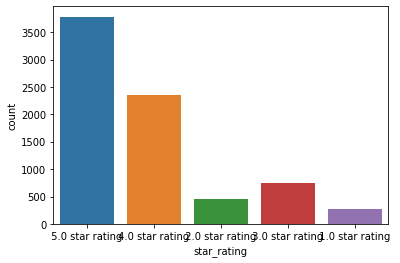

In [40]:
sns.countplot(shops['star_rating']);

In [7]:
pd.options.display.max_rows = 999

In [5]:
shops['coffee_shop_name'].describe()

count              7616
unique               79
top       Epoch Coffee 
freq                400
Name: coffee_shop_name, dtype: object

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [50]:
shops['coffee_shop_name'].value_counts()

Epoch Coffee                            400
Halcyon                                 300
The Factory - Cafe With a Soul          244
Venezia Italian Gelato                  200
Summer Moon Coffee Bar                  200
Houndstooth Coffee                      200
Caffé Medici                            143
Apanas Coffee & Beer                    136
Corona Coffee                           100
Monkey Nest Coffee                      100
Cenote                                  100
Flightpath Coffeehouse                  100
Patika                                  100
Café Java                               100
Anderson’s Coffee Company               100
Russell’s Bakery                        100
Radio Coffee & Beer                     100
Teo                                     100
TOMS                                    100
The Buzz Mill                           100
Café Crème                              100
Juan Pelota                             100
Bennu Coffee                    

In [ ]:
# Combining values for Summermoon Coffee Bar and Summer Moon Coffee Bar

In [4]:
shops['coffee_shop_name'] = shops['coffee_shop_name'].str.replace("Summermoon Coffee Bar", "Summer Moon Coffee Bar")

In [5]:
shops['full_review_text'].value_counts(normalize=True)[:25]

 until today. Glad I stopped-the famous chicken waffle was delish!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [6]:
# there are dates mixed in with the review string...
# make extra column for date:
shops['date'] = None
# specify location in df
index_description = shops.columns.get_loc('full_review_text')
# specify location in df
index_date = shops.columns.get_loc('date')
# create regex to grab dates that have 1 or 2 values for month/day and 4 for year:
date_pattern = r'([0-9]{1,2}\/[0-9]{1,2}\/[0-9]{4})'

In [7]:
# for loop to apply regex at index position 1 "index_description"
# and store the extraction in index position 3 " index_date"
for row in range(0, len(shops)):
    date = re.search(date_pattern, shops.iat[row, index_description]).group()
    shops.iat[row, index_date] = date

In [8]:
# rearrange columns
shops = shops[['date', 'coffee_shop_name', 'full_review_text', 'star_rating']]

In [9]:
# dates with most reviews recieved:
shops['date'].value_counts()[:10]

10/9/2016     31
9/18/2016     30
11/2/2016     27
11/20/2016    27
12/4/2016     26
12/2/2016     26
9/15/2016     25
7/24/2016     24
10/7/2016     24
11/6/2016     24
Name: date, dtype: int64

In [10]:
def tokenize(text):
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = tokens.lower().split()   
    return tokens

In [11]:
# tokenizing the review column with regex and forcing all lower case
shops['tokens'] = shops['full_review_text'].apply(tokenize)

In [12]:
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
shops['tokens'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words
word_counts.most_common(10)

[('the', 34809),
 ('and', 26650),
 ('a', 22755),
 ('i', 20237),
 ('to', 17164),
 ('of', 12600),
 ('is', 11999),
 ('coffee', 10353),
 ('was', 9707),
 ('in', 9546)]

In [13]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [14]:
# Use the Function
wc = count(shops['tokens'])

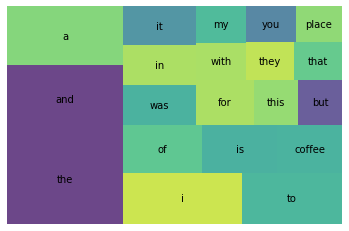

In [15]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [16]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [17]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['tokens'] = tokens

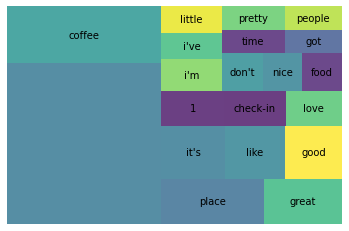

In [18]:
wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [19]:
STOP_WORDS = nlp.Defaults.stop_words.union(["i've", "i'm", "don't", "it's", "1",])

In [20]:
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

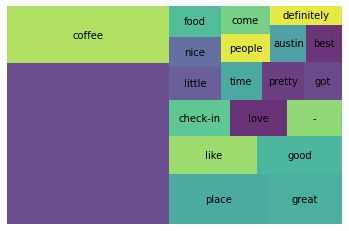

In [21]:
wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [22]:
wc_top20

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
16,,7616,22606,1.0,0.054381,0.054381,1.000000
34,coffee,4210,8058,2.0,0.019384,0.073765,0.552784
79,place,3029,4264,3.0,0.010257,0.084023,0.397715
81,great,2438,3250,4.0,0.007818,0.091841,0.320116
180,like,2034,2902,5.0,0.006981,0.098822,0.267069
171,good,2084,2779,6.0,0.006685,0.105507,0.273634
2,check-in,1957,1961,7.0,0.004717,0.110224,0.256959
41,love,1434,1806,8.0,0.004345,0.114569,0.188288
162,-,919,1773,9.0,0.004265,0.118834,0.120667
808,little,1230,1479,10.0,0.003558,0.122392,0.161502


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

